In [1]:
import math 
import random
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = _children
        self.label = label
    
    def __repr__(self) -> str:
        return f'Value(data = {self.data})'
    
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    

    def __pow__(self, other):
        assert isinstance(other, (int,float)) # only support int & float powers for now
        out = Value(self.data**other, (self,), f'^{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    
    def __neg__(self):
        return -1 * self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __rtruediv__(self, other):
        return self * (other ** -1)

    
    def sigmoid(self):
        x = self.data
        s = 1/(1+ math.exp(-x))
        out = Value(s, (self, ), 'sigmoid')

        def _backward():
            self.grad += s * (1-s) * out.grad

        out._backward = _backward
        
        return out
    
    def relu(self):
        x = self.data
        r = max(x,0)
        out = Value(r, (self, ), 'ReLU')

        def _backward():
            self.grad += 1 * out.grad if x > 0 else 0

        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def linear(self):
        x = self.data
        out = Value(x, (self, ), 'linear')

        def _backward():
            self.grad += 1 * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out
    

    def backward(self):
        topological = []
        visited = set()

        def build_topological(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topological(child)
                topological.append(v)

        build_topological(self)
        
        self.grad = 1.0
        for node in reversed(topological):
            node._backward()

In [3]:
class Neuron:
    
    def __init__(self, numIn) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(numIn)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w . x + b
        act = sum(w1*x1 for w1, x1 in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, numIn, numOut) -> None:
        self.neurons = [Neuron(numIn) for _ in range(numOut)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params
    
        
class MLP:
    def __init__(self, numIn, numOuts) -> None:
        sizes = [numIn] + numOuts 
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(numOuts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params
        

In [4]:

n = MLP(6, [50, 20, 7, 1])


In [5]:
#The features in each example represent:
#
# Size (cm)
# Texture roughness (normalized scale)
# Perimeter irregularity (normalized scale)p
# Compactness
# Symmetry deviation
# Fractal dimension

# 50 training examples
xs = [
   [2.3, 0.8, 1.2, 0.5, 0.9, 1.1], [4.7, 2.1, 3.5, 2.8, 3.2, 2.9],
   [2.1, 0.7, 1.4, 0.4, 0.8, 1.2], [5.1, 2.4, 3.2, 2.9, 3.5, 3.1],
   [2.5, 0.9, 1.1, 0.6, 1.0, 0.9], [4.9, 2.2, 3.4, 3.0, 3.1, 2.8],
   [2.2, 0.6, 1.3, 0.5, 0.7, 1.0], [4.8, 2.3, 3.3, 2.7, 3.3, 3.0],
   [2.4, 0.8, 1.2, 0.4, 0.9, 1.1], [5.0, 2.5, 3.6, 2.9, 3.4, 3.2],
   [2.3, 0.7, 1.1, 0.5, 0.8, 1.0], [4.6, 2.2, 3.4, 2.8, 3.1, 2.9],
   [2.2, 0.8, 1.3, 0.4, 0.9, 1.1], [5.2, 2.3, 3.5, 3.0, 3.3, 3.1],
   [2.4, 0.9, 1.2, 0.6, 1.0, 0.9], [4.8, 2.1, 3.3, 2.7, 3.2, 2.8],
   [2.1, 0.7, 1.4, 0.5, 0.8, 1.2], [5.0, 2.4, 3.4, 2.9, 3.4, 3.0],
   [2.5, 0.8, 1.1, 0.4, 0.9, 1.0], [4.7, 2.2, 3.5, 2.8, 3.1, 2.9],
   [2.3, 0.9, 1.3, 0.6, 1.0, 1.1], [4.9, 2.3, 3.3, 2.7, 3.3, 3.0],
   [2.2, 0.7, 1.2, 0.5, 0.8, 0.9], [5.1, 2.4, 3.6, 3.0, 3.4, 3.2],
   [2.4, 0.8, 1.1, 0.4, 0.9, 1.0], [4.8, 2.2, 3.4, 2.8, 3.2, 2.9],
   [2.1, 0.6, 1.4, 0.5, 0.7, 1.2], [5.0, 2.3, 3.5, 2.9, 3.3, 3.1],
   [2.5, 0.9, 1.2, 0.6, 1.0, 0.9], [4.7, 2.1, 3.3, 2.7, 3.1, 2.8],
   [2.3, 0.7, 1.1, 0.4, 0.8, 1.0], [4.9, 2.4, 3.4, 3.0, 3.4, 3.2],
   [2.2, 0.8, 1.3, 0.5, 0.9, 1.1], [5.2, 2.2, 3.6, 2.8, 3.2, 2.9],
   [2.4, 0.9, 1.2, 0.6, 1.0, 0.9], [4.8, 2.3, 3.3, 2.7, 3.3, 3.0],
   [2.1, 0.7, 1.4, 0.4, 0.8, 1.2], [5.0, 2.4, 3.5, 2.9, 3.4, 3.1],
   [2.5, 0.8, 1.1, 0.5, 0.9, 1.0], [4.7, 2.2, 3.4, 2.8, 3.1, 2.9],
   [2.3, 0.6, 1.3, 0.6, 0.7, 1.1], [4.9, 2.1, 3.3, 2.7, 3.2, 2.8],
   [2.2, 0.9, 1.2, 0.4, 1.0, 0.9], [5.1, 2.3, 3.6, 3.0, 3.3, 3.2],
   [2.4, 0.7, 1.1, 0.5, 0.8, 1.0], [4.8, 2.4, 3.4, 2.8, 3.4, 2.9]
]

# Labels: -1 for benign, 1 for malignant
ys = [-1, 1, -1, 1, -1, 1, -1, 1, -1, 1,
     -1, 1, -1, 1, -1, 1, -1, 1, -1, 1,
     -1, 1, -1, 1, -1, 1, -1, 1, -1, 1,
     -1, 1, -1, 1, -1, 1, -1, 1, -1, 1,
     -1, 1, -1, 1, -1, 1, -1, 1, -1, 1]



In [6]:
# Training Loop
# Using MSE loss
losses = []
for k in range(150):

    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    losses.append(loss)

    # Backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    # Update
    for p in n.parameters():
        p.data += -0.001 * p.grad

    print (k, loss.data)



0 75.3053038742254
1 50.33334774805417
2 46.58546929555294
3 33.7197619732398
4 57.20180590130044
5 37.38795263981728
6 22.125308148829667
7 13.775878585858585
8 9.787914292709662
9 7.005933819935024
10 6.2476112256916645
11 5.657336154564428
12 5.1716472641923446
13 4.759993363679512
14 4.4043611246760515
15 4.093047679882792
16 3.8178696759802997
17 3.5727866118104745
18 3.353160655775047
19 3.155326672268829
20 2.9763249526773614
21 2.813725278785184
22 2.6655055288826848
23 2.529964698230465
24 2.40565868758687
25 2.2913517638456384
26 2.185979163317408
27 2.0886178264010735
28 1.99846319152613
29 1.9148105814022989
30 1.837040118928354
31 1.7646043887277931
32 1.6970182572390167
33 1.6338504064028587
34 1.5747162401978916
35 1.519271900658553
36 1.4672091880619649
37 1.4182512238868847
38 1.3721487286234306
39 1.3286768122096477
40 1.2876321947370493
41 1.2488307905369316
42 1.2121056008963291
43 1.1773048702495115
44 1.144290468340542
45 1.1129364669993373
46 1.0831278851528303
4

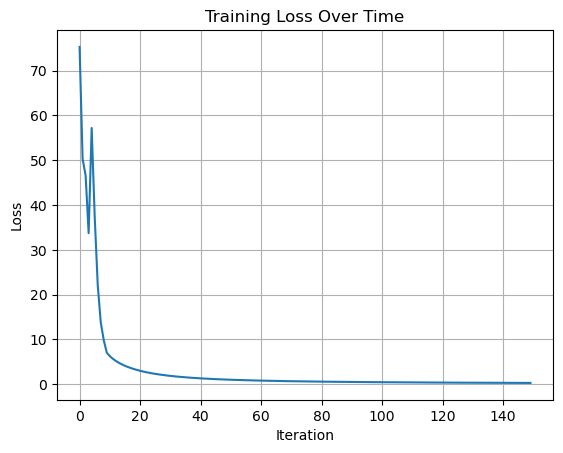

In [7]:
import matplotlib.pyplot as plt

losses_data = []
for i in losses:
    losses_data.append(i.data)

plt.plot(losses_data)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

In [ ]:
# 20 test examples
test_xs = [
   [2.2, 0.7, 1.1, 0.4, 0.8, 1.0], [4.9, 2.3, 3.4, 2.8, 3.3, 2.9],
   [2.4, 0.9, 1.3, 0.5, 1.0, 1.2], [5.2, 2.4, 3.5, 3.0, 3.4, 3.1],
   [2.1, 0.6, 1.2, 0.4, 0.7, 0.9], [4.8, 2.2, 3.3, 2.7, 3.2, 2.8],
   [2.3, 0.8, 1.1, 0.5, 0.9, 1.1], [5.0, 2.3, 3.6, 2.9, 3.3, 3.0],
   [2.5, 0.7, 1.4, 0.6, 0.8, 1.0], [4.7, 2.1, 3.4, 2.8, 3.1, 2.9],
   [2.2, 0.9, 1.2, 0.4, 1.0, 0.9], [5.1, 2.4, 3.5, 3.0, 3.4, 3.2],
   [2.4, 0.6, 1.3, 0.5, 0.7, 1.2], [4.9, 2.2, 3.3, 2.7, 3.2, 2.8],
   [2.1, 0.8, 1.1, 0.4, 0.9, 1.0], [5.0, 2.3, 3.4, 2.9, 3.3, 3.1],
   [2.3, 0.7, 1.4, 0.6, 0.8, 1.1], [4.8, 2.1, 3.5, 2.8, 3.1, 2.9],
   [2.5, 0.9, 1.2, 0.5, 1.0, 0.9], [5.2, 2.4, 3.6, 3.0, 3.4, 3.2]
]

test_ys = [-1, 1, -1, 1, -1, 1, -1, 1, -1, 1,
          -1, 1, -1, 1, -1, 1, -1, 1, -1, 1]

test_pred_prob = [n(x) for x in test_xs]
test_pred = []

for y in test_pred_prob:
    test_pred.append(1) if y.data >=0 else test_pred.append(-1) 

false_pred = 0
i = 1
for pred, ygt in zip(test_pred, test_ys):
    print(f'test example {i} : ygt:{ygt} | ŷ:{pred}')
    if pred != ygt: false_pred += 1
    i += 1
print(f'Accuracy = {1-(false_pred/(len(test_ys)+1))}')

test example 1 : ygt:-1 | ŷ:-1
test example 2 : ygt:1 | ŷ:1
test example 3 : ygt:-1 | ŷ:-1
test example 4 : ygt:1 | ŷ:1
test example 5 : ygt:-1 | ŷ:-1
test example 6 : ygt:1 | ŷ:1
test example 7 : ygt:-1 | ŷ:-1
test example 8 : ygt:1 | ŷ:1
test example 9 : ygt:-1 | ŷ:-1
test example 10 : ygt:1 | ŷ:1
test example 11 : ygt:-1 | ŷ:-1
test example 12 : ygt:1 | ŷ:1
test example 13 : ygt:-1 | ŷ:-1
test example 14 : ygt:1 | ŷ:1
test example 15 : ygt:-1 | ŷ:-1
test example 16 : ygt:1 | ŷ:1
test example 17 : ygt:-1 | ŷ:-1
test example 18 : ygt:1 | ŷ:1
test example 19 : ygt:-1 | ŷ:-1
test example 20 : ygt:1 | ŷ:1
Accuracy = 1.0


: 

In [13]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

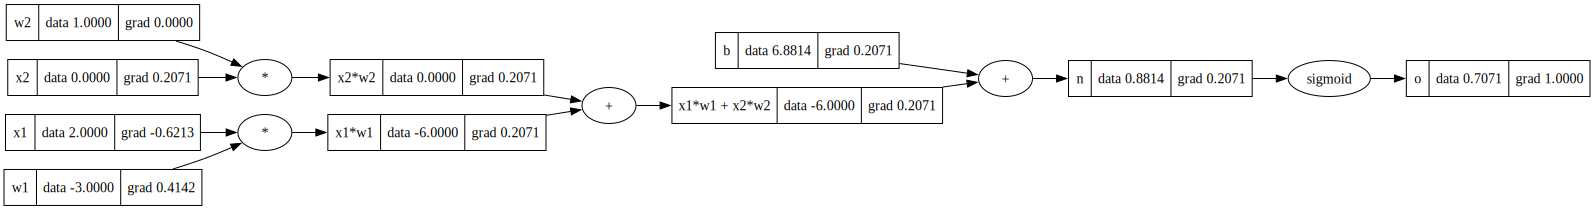

In [14]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.sigmoid(); o.label = 'o'

o.backward()
draw_dot(o)


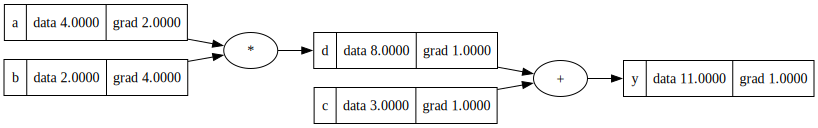

In [15]:
# y = (a * b) + c 
a = Value(4.0, label='a')
b = Value(2.0, label='b')
c = Value(3.0, label='c')

d = a * b
d.label = 'd'

y = d + c
y.label = 'y'

y.backward()
draw_dot(y)

# dy/da = b = 2
# dy/db = a = 4
# dy/dc = 1